In [1]:
import numpy as np
from sklearn import linear_model
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv('startup_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

In [2]:
#Label encoding and create pairs
le = LabelEncoder()
df["city_label"] = le.fit_transform(df["city"])
df["state_label"] = le.fit_transform(df["state_code"])
df["cat_label"] = le.fit_transform(df["category_code"])

#For later reference get label-string pairs
city_plus_labels = df[["city_label","city"]]
states_plus_labels = df[["state_label","state_code"]]
cat_plus_labels = df[["cat_label","category_code"]]

#Create input, output set
X = df[["has_VC","has_angel","city_label","state_label","cat_label"]]              
y = df["labels"]

#Create train test split where data is shuffled but in the same way every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=42)

In [3]:
#Create logistic regression model and calculate accuracy based on the above criteria
model = linear_model.LogisticRegression()
model.fit(X_train,y_train)
y_hat = model.predict(X_test)
accuracy = accuracy_score(y_test,y_hat)
print(f"Looking at the following criteria only: investor type, location, business area; our model achived an accuracy score of: {accuracy*100:.2f}%")

Looking at the following criteria only: investor type, location, business area; our model achived an accuracy score of: 60.54%


In [4]:
#Logistic regression, but including all numerical features

#Get features with numerical values and drop rows with Nan
numeric=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.select_dtypes(include=numeric).dropna()
df_num.head()

#Create input, output dataset
X = df_num.loc[:,df_num.columns != "labels"].drop(columns="Unnamed: 0")
y = df_num["labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=42)
model.fit(X_train,y_train)
y_hat = model.predict(X_test)
accuracy = accuracy_score(y_test,y_hat)
print(f"Looking at every numerical feature, our model achived an accuracy score of: {accuracy*100:.2f}%")

Looking at every numerical feature, our model achived an accuracy score of: 74.19%


In [5]:
#Compare it with decision tree
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import display, Image

dtree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=4)
dtree.fit(X_train,y_train)
yhat_dtree = dtree.predict(X_test)
accuracy = accuracy_score(y_test,yhat_dtree)
print(f"Looking at every numerical feature, our decision tree model achived an accuracy score of: {accuracy*100:.2f}%")

Looking at every numerical feature, our decision tree model achived an accuracy score of: 79.35%


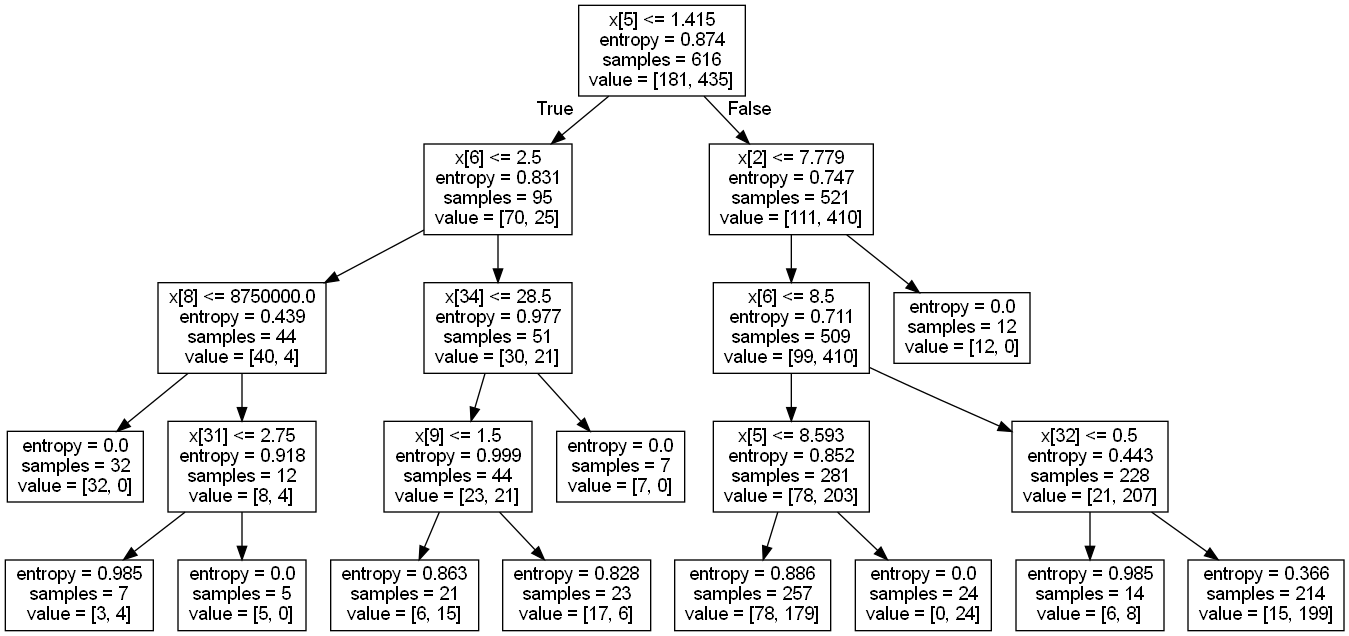

In [6]:
#Show decision tree
dot_data = export_graphviz(dtree, out_file=None) 
graph = graphviz.Source(dot_data)
image = graph.render(format='png')
display(Image(image))

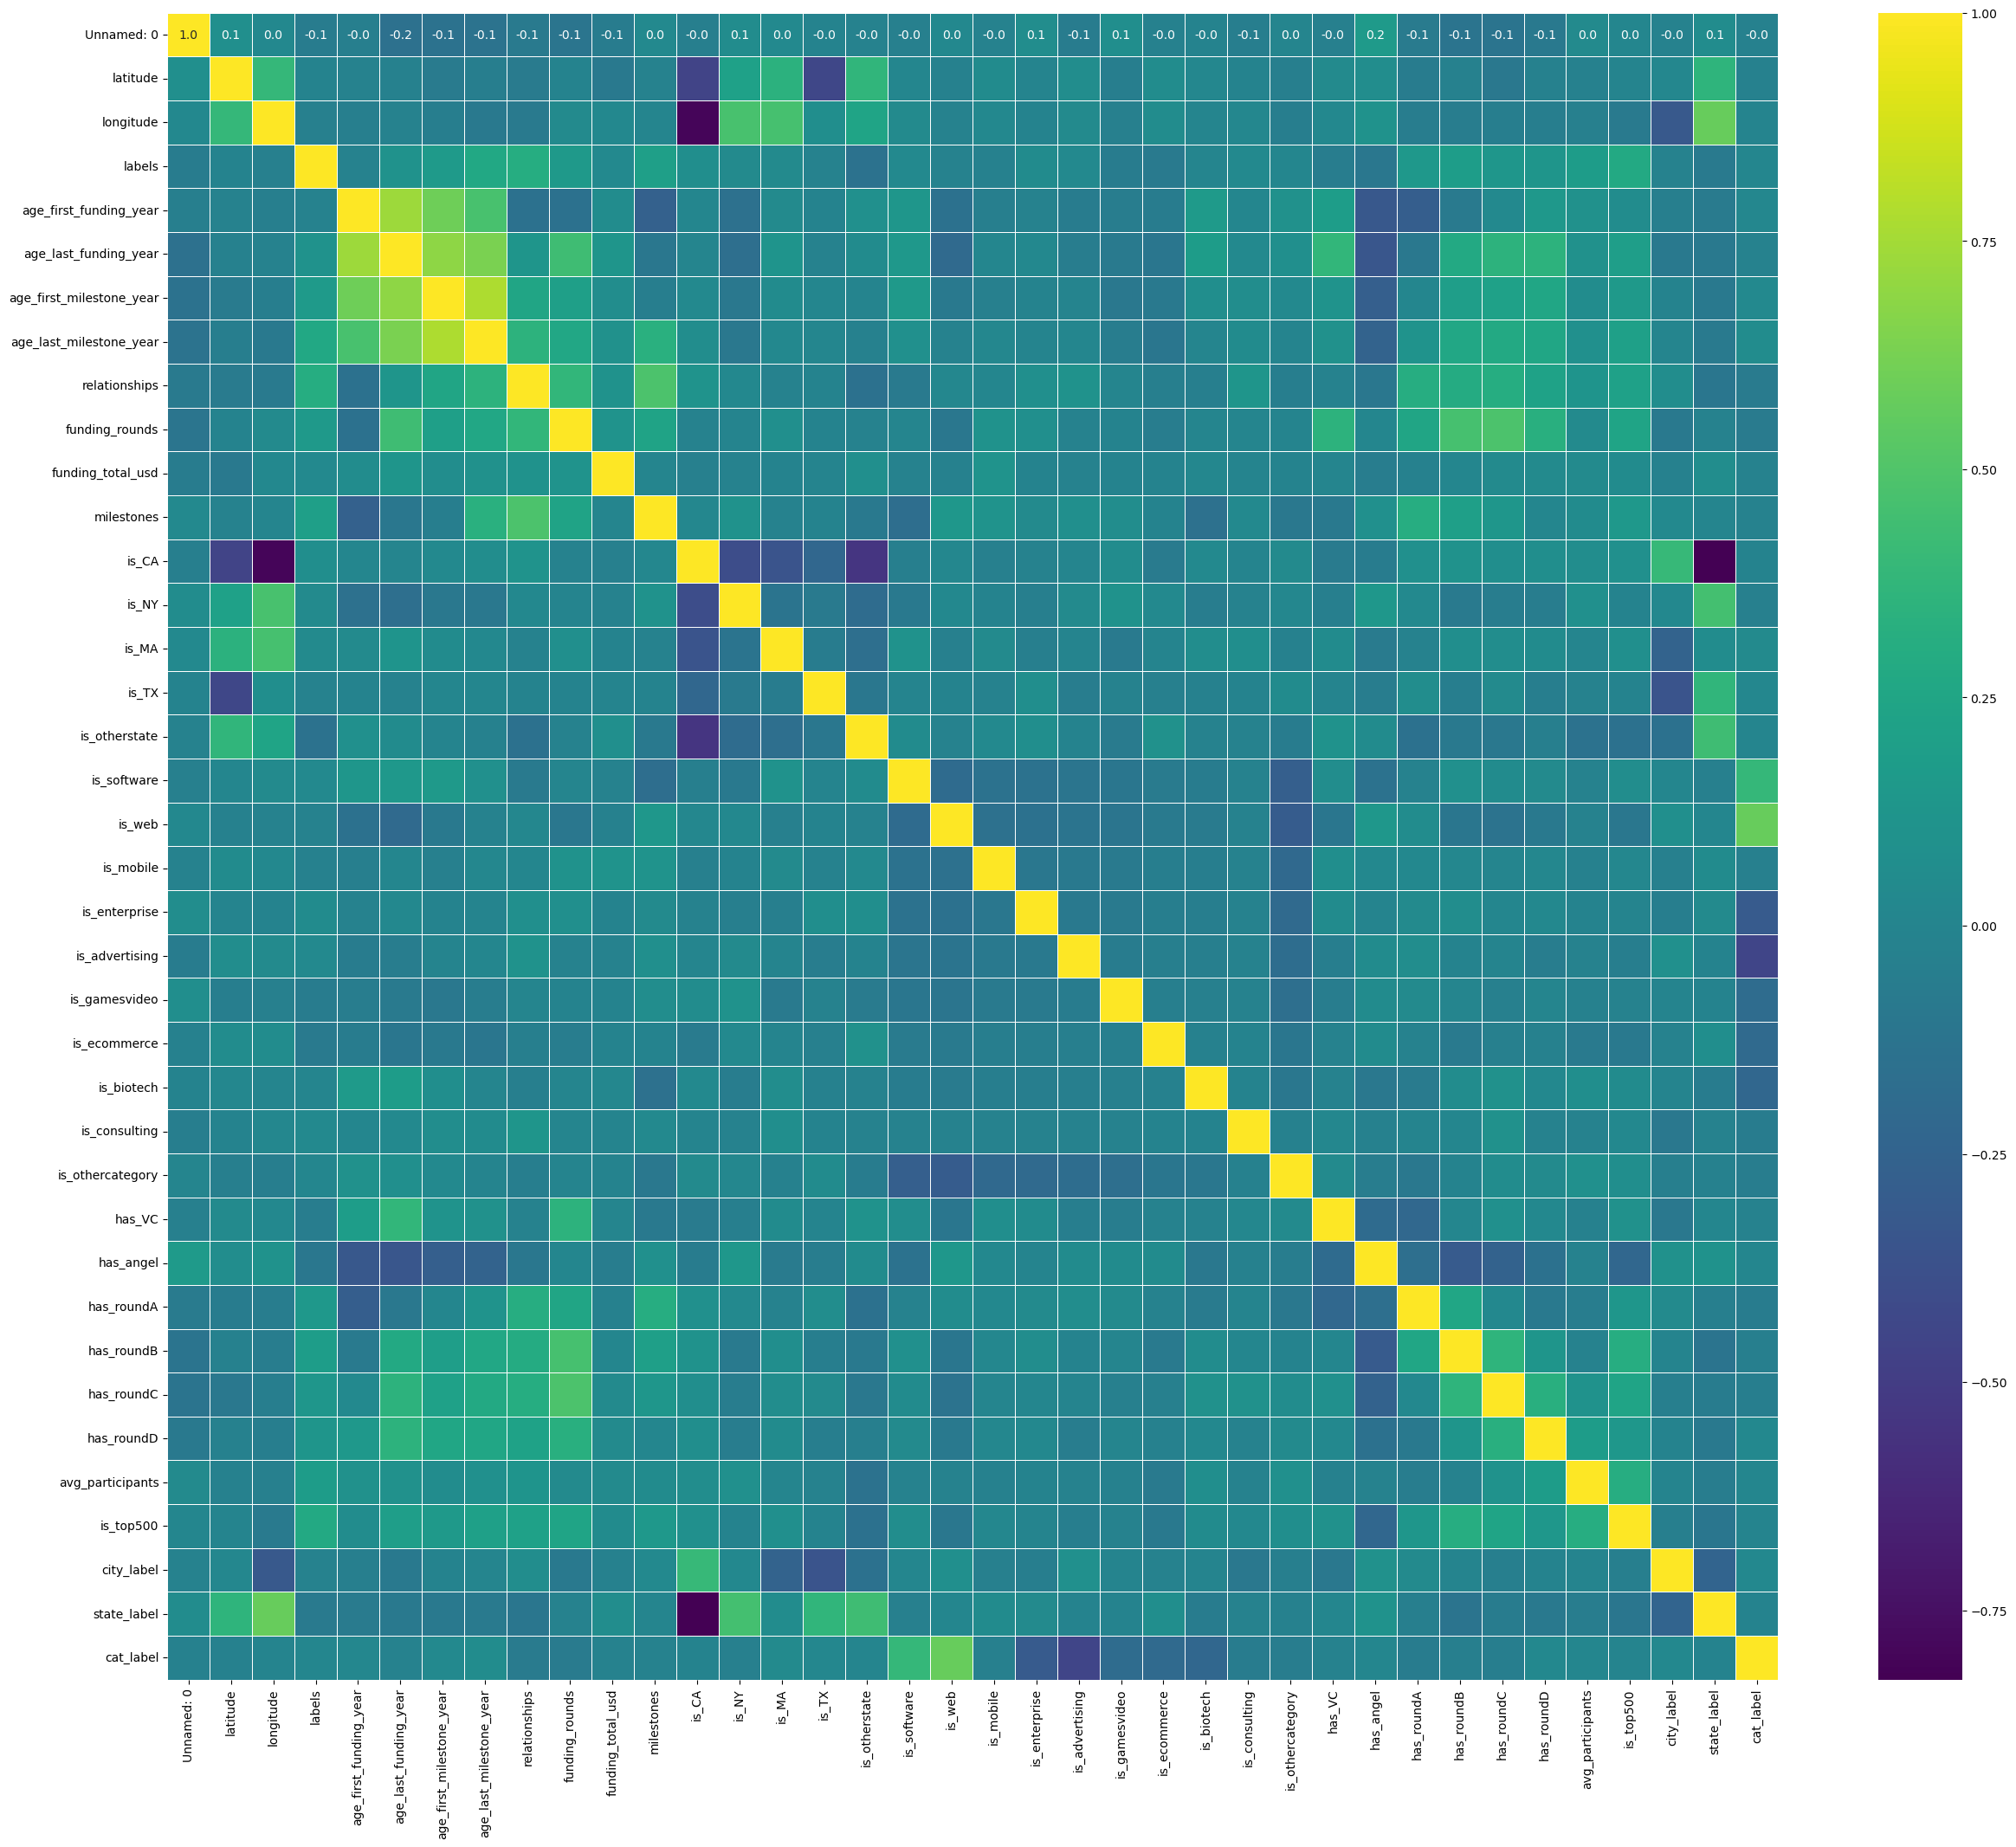

In [7]:
#Create heatmap
plt.figure(figsize = (30, 25))
sns.heatmap(df_num.corr(),annot = True, cmap = 'viridis', linewidth = 0.5, fmt = '.1f')
plt.show()

In [8]:
#Sort features by log-odds (=correlation to startup success)


#Get features as list
features = list(X)
print(features)

#Create feature-coeff pairs
coeffs = pd.DataFrame(model.coef_, columns=features)
print(coeffs)
coeffs = coeffs.transpose().reset_index()
coeffs.columns = ["feature", "coeff"]
print(coeffs)
#Sort by coefficient magnitude
sorted_df = coeffs.sort_values(axis=0, by="coeff", ascending=False)
print("\n")
print(sorted_df)

['latitude', 'longitude', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'is_top500', 'city_label', 'state_label', 'cat_label']
       latitude     longitude  age_first_funding_year  age_last_funding_year  \
0  4.565774e-13 -1.196250e-12            1.620693e-14           4.038710e-14   

   age_first_milestone_year  age_last_milestone_year  relationships  \
0              5.039836e-14             9.020507e-14   1.886002e-13   

   funding_rounds  funding_total_usd    milestones  ...     has_angel  \
0    2.977465e-14       2.860622e-08  3.707971e-14  ...  

Second largest cofficient: 1.4234363116733222e-12

Top 15 features as dataframe:

                     feature         coeff
0          funding_total_usd  2.860622e-08
1                 city_label  1.423436e-12
2                   latitude  4.565774e-13
3                  cat_label  2.680209e-13
4              relationships  1.886002e-13
5                state_label  9.469223e-14
6    age_last_milestone_year  9.020507e-14
7   age_first_milestone_year  5.039836e-14
8           avg_participants  4.625816e-14
9      age_last_funding_year  4.038710e-14
10                milestones  3.707971e-14
11            funding_rounds  2.977465e-14
12    age_first_funding_year  1.620693e-14
13                 is_top500  1.360760e-14
14                has_roundA  9.794354e-15


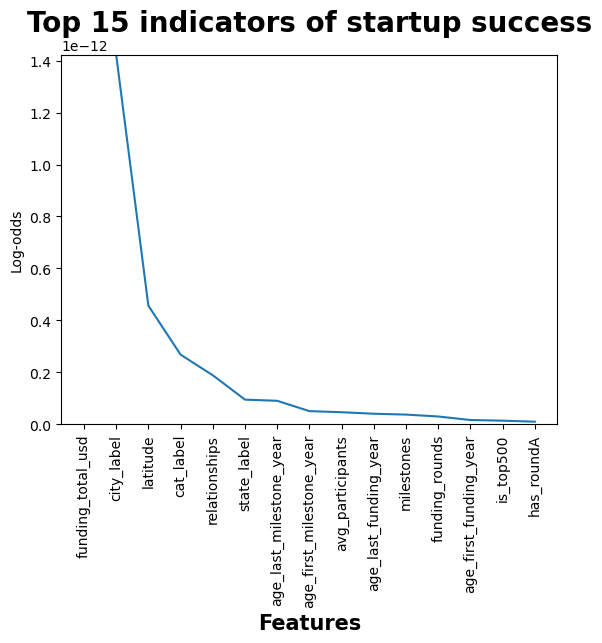

In [9]:
#Choose number of top features to represent
top = 15
plot_df = sorted_df.head(top).reset_index().drop(columns="index")
#Select start of plot as second biggest value to avoid un-intuitive graph
plot_y_start = plot_df["coeff"].nlargest(2)[1]
print(f"Second largest cofficient: {plot_y_start}\n")
print(f"Top {top} features as dataframe:\n\n{plot_df}")
#Plot graph
plt.plot(plot_df["feature"],plot_df["coeff"])
plt.xlabel("Features",fontweight="bold",fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Log-odds")
plt.ylim(0,plot_y_start)
plt.title(f"Top {top} indicators of startup success",fontweight="bold",fontsize=20)
plt.show()

C:\Users\Gamer\anaconda-ai\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gamer\anaconda-ai\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gamer\anaconda-ai\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gamer\anaconda-ai\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

Text(0.5, 1.0, 'Category distribution of successful startups')

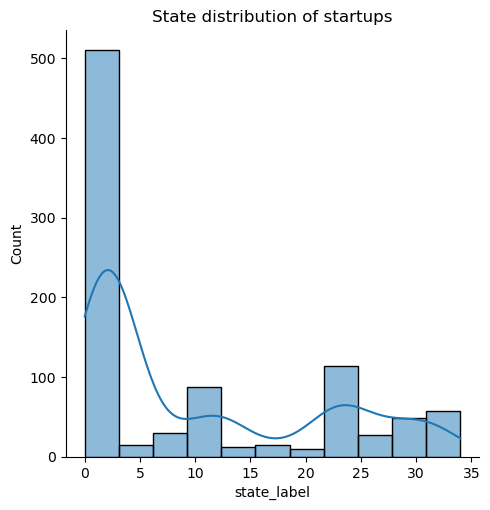

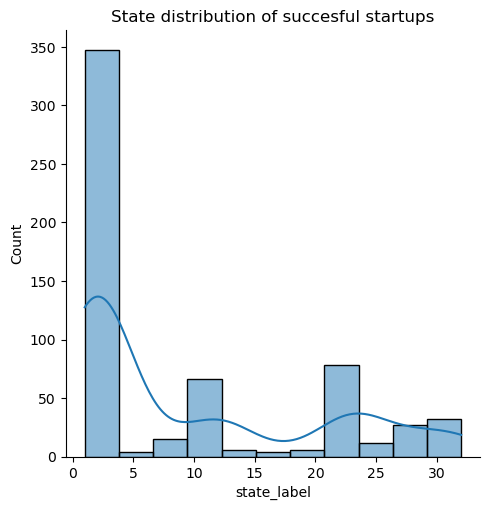

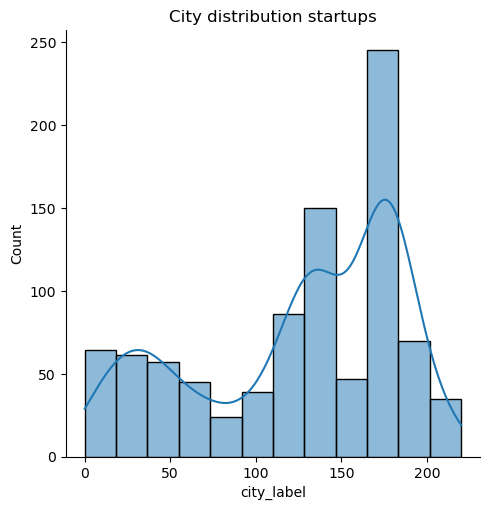

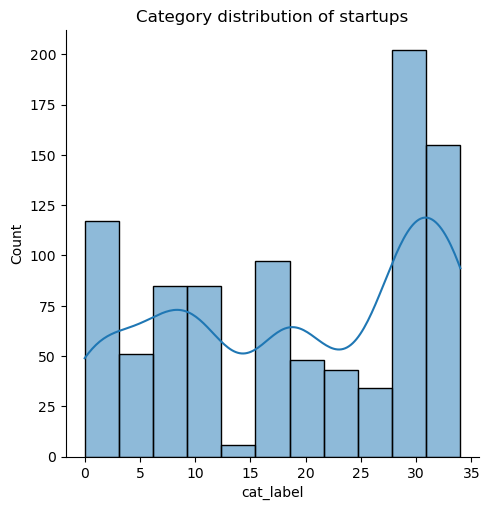

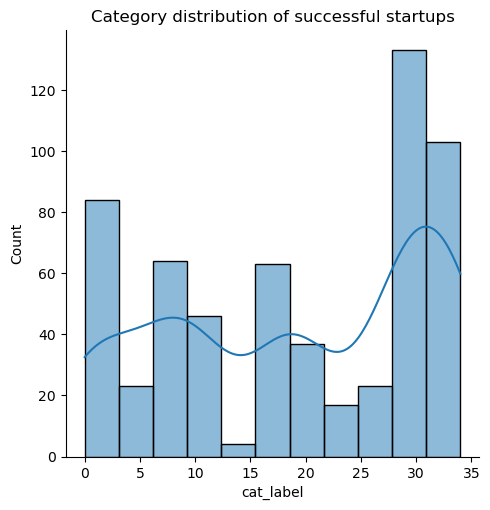

In [10]:
#Creating graphs to compare: successful vs. unsuccessful startups distribution per category and state + distribuiton of startups per city

sns.displot(df["state_label"],kde=True)
plt.title("State distribution of startups")

df_success = df[["state_label","labels"]][df.labels != 0]
sns.displot(df_success["state_label"],kde=True)
plt.title("State distribution of succesful startups")


sns.displot(df["city_label"],kde=True)
plt.title("City distribution startups")


sns.displot(df["cat_label"],kde=True)
plt.title("Category distribution of startups")

df_success = df[["cat_label","labels"]][df.labels != 0]
sns.displot(df_success["cat_label"],kde=True)
plt.title("Category distribution of successful startups")